## Import packages

In [22]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ProgressBar

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [23]:
pd.options.display.max_columns = 40

In [24]:
from XAI.functions import create_confusion_matrix

## Load dataset

In [25]:
df = pd.read_csv('../data/CVD_cleaned.csv')
df = df.dropna() # some rows are not correctly loaded 
print(df.shape)
df.head(3)

(299312, 19)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0


## preprocess data

In [26]:
binary_columns = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Arthritis', 'Smoking_History','Exercise', 'Diabetes']

for column in binary_columns:
    df[column] = df[column].map({'Yes': 1, 'No': 0})
    
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'Female' else 0)

mapping = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Very Good': 3,
    'Excellent': 4,
}
df['General_Health'] = df['General_Health'].replace(mapping)

mapping = {
    '18-24': 0,
    '25-29': 1,
    '30-34': 2,
    '35-39': 3,
    '40-44': 4,
    '45-49': 5,
    '50-54': 6,
    '55-59': 7,
    '60-64': 8,
    '65-69': 9,
    '70-74': 10,
    '75-79': 11,
    '80+': 12,
}
df['Age_Category'] = df['Age_Category'].replace(mapping)

mapping = {
    'Never': 0,
    '5 or more years ago': 1,
    'Within the past 5 years': 2,
    'Within the past 2 years': 3,
    'Within the past year': 4,
}
df['Checkup'] = df['Checkup'].replace(mapping)

In [27]:
print(df.shape)
print()
print(df.groupby('Heart_Disease').size())
print()
df.head(3)

(299312, 19)

Heart_Disease
0    275231
1     24081
dtype: int64



,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,0,3,0,0,0,0,0,0,1,1,10,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,3,4,0,1,0,0,0,1,0,1,10,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,3,4,1,0,0,0,0,1,0,1,8,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0


In [28]:
# Split the data into train and test sets
df_test = pd.concat(
    [df[df['Heart_Disease']==0].sample(50_000, random_state=1),
     df[df['Heart_Disease']==1]]
) # For the exercise I'm making more equal samples

y = df_test['Heart_Disease']
X = df_test.drop(['Heart_Disease'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Model 1 - Random Forest

Train accuracy: 0.7881175755939525
Test accuracy: 0.7672268340419788


<module 'matplotlib.pyplot' from '/Users/eq81tw/Developer/xai-hackathon/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

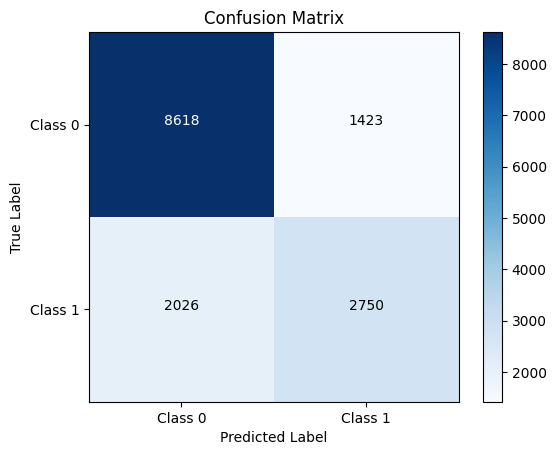

In [29]:
# Create the model
model_rf = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=40)

# Train the model
model_rf.fit(X_train.values, y_train)

# Get predictions
train_preds = model_rf.predict(X_train.values)
test_preds = model_rf.predict(X_test.values)

# Calculate and print the accuracy
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

create_confusion_matrix(y_test, test_preds)

## Model 2 - XGBoost

Train accuracy: 0.7734543736501079
Test accuracy: 0.7685766349463454


<module 'matplotlib.pyplot' from '/Users/eq81tw/Developer/xai-hackathon/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

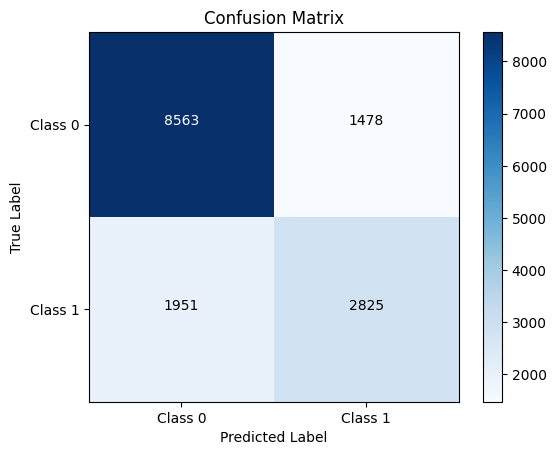

In [30]:
# Convert the dataset to DMatrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for xgboost
param = {
    'max_depth': 3,  # Maximum depth of the trees
    'eta': 0.3,  # Learning rate
    'objective': 'multi:softmax',  # Loss function
    'num_class': 2,  # Number of classes
    'seed': 1,
}

# Train the model
num_round = 20  # Number of training rounds
model_xgb = xgb.train(param, dtrain, num_round)

# Get predictions
train_preds = model_xgb.predict(dtrain)
test_preds = model_xgb.predict(dtest)

# Calculate and print the accuracy
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

create_confusion_matrix(y_test, test_preds)

## Model 3 - Create NN model

In [11]:
from XAI.nn import BinaryClassifier, SilentProgressBar, get_predictions

In [12]:
train_data = TensorDataset(torch.from_numpy(X_train.to_numpy().astype(np.float32)), torch.from_numpy(y_train.values))
test_data = TensorDataset(torch.from_numpy(X_test.to_numpy().astype(np.float32)), torch.from_numpy(y_test.values))

train_mean = np.array(X_train.mean(axis=0))
train_std = np.array(X_train.std(axis=0))

## Model 3 - Fit NN Model 

In [18]:
# Training the model
model_nn = BinaryClassifier(torch.from_numpy(train_mean), torch.from_numpy(train_std), num_cols=X_train.shape[1])
bar = SilentProgressBar()
logger = TensorBoardLogger('tb_logs', name='my_model')

In [19]:
trainer = pl.Trainer(max_epochs=20, callbacks=[bar], logger=logger)
trainer.fit(model_nn, DataLoader(train_data, batch_size=64), DataLoader(test_data, batch_size=64))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [14]:
# %load_ext tensorboard
# %tensorboard --logdir tb_logs/ --port 6014

Train accuracy: 0.7677510799136069
Test accuracy: 0.7641897820071539


<module 'matplotlib.pyplot' from 'C:\\Users\\WJ03DC\\Anaconda3\\envs\\xai_hackathon\\Lib\\site-packages\\matplotlib\\pyplot.py'>

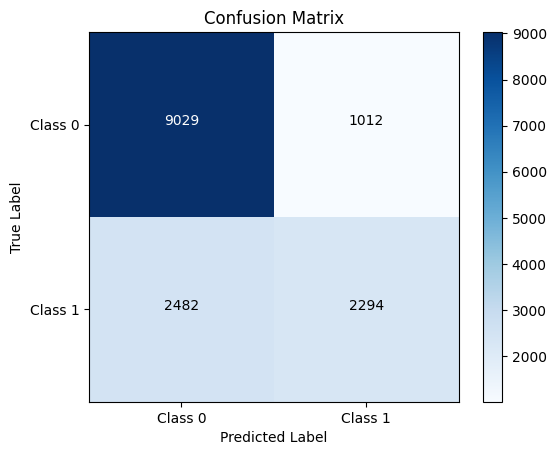

In [15]:
train_loader = DataLoader(train_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

train_preds = get_predictions(model_nn, train_loader)
test_preds = get_predictions(model_nn, test_loader)

# Calculate and print the accuracy
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

create_confusion_matrix(y_test, test_preds)

## Save data + models

In [31]:
X_train.to_csv('../data/X_train.csv', index = False)
X_test.to_csv('../data/X_test.csv', index = False)
y_train.to_csv('../data/y_train.csv', index = False)
y_test.to_csv('../data/y_test.csv', index = False)

In [32]:
pickle.dump(model_rf, open('../models/model_rf.sav', 'wb'))
pickle.dump(model_xgb, open('../models/model_xgb.sav', 'wb'))
pickle.dump(model_nn, open('../models/model_nn.sav', 'wb'))